<a href="https://colab.research.google.com/github/MubashirullahD/road-sign-dataset/blob/main/IEngineering_Assignment_mubashir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import re 
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data

In [2]:
!git clone https://github.com/MubashirullahD/road-sign-dataset.git

fatal: destination path 'road-sign-dataset' already exists and is not an empty directory.


In [3]:
images_dir = "/content/road-sign-dataset/images"
images_name = os.listdir(images_dir)
print((images_name))

['image (1).jpg', 'image (27).jpg', 'image (18).jpg', 'image (17).jpg', 'image (34).jpg', 'image (6).jpg', 'image (5).jpg', 'image (11).jpg', 'image (10).jpg', 'image (23).jpg', 'image (9).jpg', 'image (26).jpg', 'image (4).jpg', 'image (31).jpg', 'image (25).jpg', 'image (29).jpg', 'image (30).jpg', 'image (24).jpg', 'image (33).jpg', 'image (28).jpg', 'image (14).jpg', 'image (16).jpg', 'image (12).jpg', 'image (20).jpg', 'image (15).jpg', 'image (3).jpg', 'image (19).jpg', 'image (8).jpg', 'image (21).jpg', 'image (22).jpg', 'image (2).jpg', 'image (35).jpg', 'image (32).jpg', 'image (13).jpg', 'image (7).jpg']


### Label and save dataset

In [4]:
Golden_labels = ['Pentagon', 'Octagon', 'Horizontal Rectangle', 'Square', 'Diamond', 'Vertical Rectangle', 'Circle']
Golden_nums = {k:i for i, k in enumerate(Golden_labels)}
print(Golden_nums)

{'Pentagon': 0, 'Octagon': 1, 'Horizontal Rectangle': 2, 'Square': 3, 'Diamond': 4, 'Vertical Rectangle': 5, 'Circle': 6}


In [5]:
def get_number(filename):
  """
  Get filename and return the number
  Input: 'image (1).jpg'
  Output: 1
  """
  return int(re.search(r'\d+', filename).group())

In [6]:
def get_label(filename):
  """
  Input: String, image file name
  Output: String, shape of image
  
  Get filename of image as input
  Extract the number in the name
  Use number to get the index of the golden label.
  """
  number = get_number(filename)
  label_index = (number-1) // 5  # Logic for indexing

  return Golden_labels[label_index]


In [7]:
MAX_WIDTH, MAX_HEIGHT = 0, 0 # Had a padding purpose that didn't work out. {Truncated}

# Save the images (ndarray) and its labels, as values of a dictionary 
# dataset['filename'] = (image ndarray, label)
dataset = {} 

for filename in images_name:

  img = cv2.imread(images_dir + '/' +  filename)
  h, w, _ = (img.shape)

  MAX_HEIGHT = h if h > MAX_HEIGHT else MAX_HEIGHT 
  MAX_WIDTH  = w if w > MAX_WIDTH  else MAX_WIDTH

  dataset[filename] = (img, get_label(filename))


MAX_HEIGHT = math.ceil(MAX_HEIGHT / 10) * 10 # Logic to round off to the nearest 10th, 256 -> 260
MAX_WIDTH  = math.ceil(MAX_WIDTH / 10) * 10
MAX_DIM = max(MAX_HEIGHT, MAX_WIDTH)
DIM = 50 

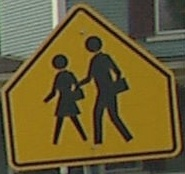

Pentagon


In [8]:
from google.colab.patches import cv2_imshow
test_image = dataset['image (1).jpg']
cv2_imshow(test_image[0])
print(test_image[1])

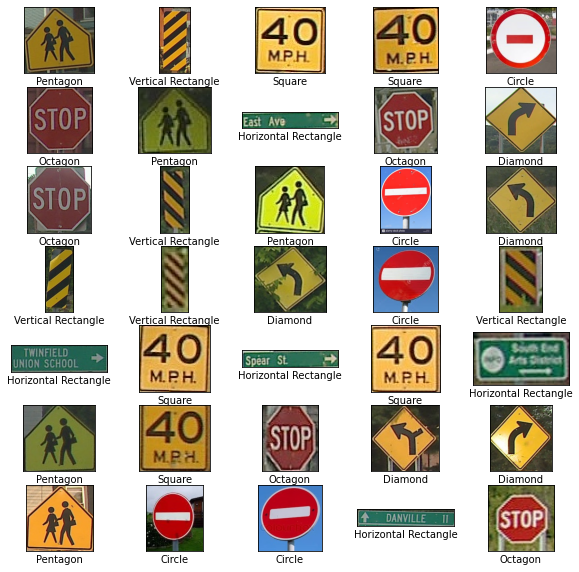

In [9]:
plt.figure(figsize=(10,10))
for i, k in enumerate(dataset):
    plt.subplot(7,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dataset[k][0][...,::-1], cmap=plt.cm.binary) #Cv2 has it in BGR, the indexing is to get RGB
    plt.xlabel(dataset[k][1])
plt.show()

## Process Data
- Make Train and Test Set
- Augment train set
- Do image processing 

In [10]:
def image_processing(dataset, filter='c'):
  """
  Need to fix size issue.
  Maybe padding, get max sizes and store them
  Do padding based on those sizes

  Filter for edge detection can be:
  c: Canny
  s: Sobel
  l: Laplacian
  n: None

  """
  processed_dataset = {}
  for filename, image_label in dataset.items():
    img, label = image_label

    # Convert it to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # remove possible noise
    if filter != 'c':
      img = cv2.GaussianBlur(img, (3,3), 0) # The canny process includes noise reduction

    if filter == 'l':
      # Edge detection throw Laplacian Kernel (Issues faced, REMOVED)
      Laplacian = cv2.Laplacian(img,cv2.CV_64F)
      img = Laplacian

    elif filter == 's':
      # Edge detection with Sobel
      sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)     # Calcution of Sobelx 
      sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)     # Calculation of Sobely 
      sobelxy = sobelx + sobely   # Add the two
      img = sobelxy
    elif filter == 'c':
      canny = cv2.Canny(img,100,200)
      img = canny
    elif filter == 'n':
      None

    # Normalize
    img = img / 255

    # Resize
    h, w = img.shape
    scale = 50
    #dim = (w * scale // 100, h * scale // 100) # Note, resize takes (w,h)
    #dim = (DIM, DIM)
    dim = (scale, scale)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_LINEAR)

    # Padding
    #h, w = img.shape
    #pad_h = math.ceil((DIM - h) / 2)  # We divide by two since the function takes each direction separatly.
    #pad_w = math.ceil((DIM - w) / 2)

    #img = cv2.copyMakeBorder(img, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_CONSTANT, value = [0, 0, 0])
    #img = cv2.resize(img, (DIM, DIM), interpolation = cv2.INTER_LINEAR) # Paddings can be off by one due to odd sizes. This fixes it

    processed_dataset[filename] = (img, label)
    
  return processed_dataset

In [11]:
def removeSmallComponents(dataset):
  """
  Testing Connected Components {Truncated, did not produce good results}
  """
  new_dataset = {}
  for filename, image_label in dataset.items():
    image, label = image_label

    # Convert it to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # applying Otsu thresholding as an extra flag in binary thresholding      
    ret, image = cv2.threshold(image, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 

    #find all your connected components (white blobs in your image)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[1:, -1]; nb_components = nb_components - 1

    img2 = np.zeros((output.shape),dtype = np.uint8)
    #for every component in the image, you keep it only if it's above threshold
    for i in range(0, nb_components):
        if sizes[i] >= ret:
            img2[output == i + 1] = 255
    
    # Resize
    h, w = img2.shape
    dim = (DIM, DIM)
    img2 = cv2.resize(img2, dim, interpolation = cv2.INTER_LINEAR)

    new_dataset[filename] = (img2, label)
  return new_dataset 

### Visualize the processed data

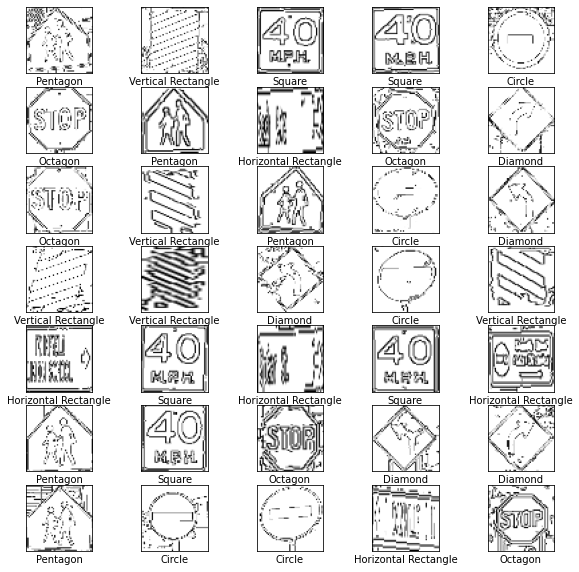

In [12]:
processed_dataset = image_processing(dataset, 'c') 
plt.figure(figsize=(10,10))
for i, k in enumerate(processed_dataset):
    plt.subplot(7,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(processed_dataset[k][0], cmap=plt.cm.binary) 
    plt.xlabel(processed_dataset[k][1])
plt.show()

In [13]:
def custom_train_test_split(dataset, test_size=1, seed=0):
  """
  Takes a dataset dictionary and creates a train and test split based on the seed
  seed can have values between 0-4
  Testsize is literally the number of images in test

  Return train and test dictionary sub-datasets
  """
  
  train = {}
  test  = {}

  if test_size < 1:
    test_size = 1 ; print("Test size set to one.")
  
  if seed not in [0, 1, 2, 3, 4]:
    seed = 1; print("Setting seed to 1")

  for filename, image_label in dataset.items():
    number = get_number(filename)

    if ((number + seed) % 5) > (test_size - 1):
      train[filename] = image_label
    else:
      test[filename] = image_label

  return (train, test)
  

In [14]:
def data_augmentation(dataset):
  """
  Get data and apply transformations: vertical and horizontal flip only.
  We avoid +-90 rotation as a transformation as it will effect some shapes.
  Maybe slight rotations can be done to mimic real work occurances of signs being on different plains.
  This has been left for the future: cv2.rotate(img, cv2.ROTATE_180)
  """
  vertical = "V_flip_"
  horizontal = "H_flip_"
  augmented_train = dataset.copy()

  for filename, image_label in dataset.items():
    img, label = image_label

    nameV_tmp = vertical + filename
    nameH_tmp = horizontal + filename
    nameVH_tmp = vertical + horizontal + filename

    augmented_train[nameV_tmp]  = (cv2.flip(img, 0), label)
    augmented_train[nameH_tmp]  = (cv2.flip(img, 1), label)
    augmented_train[nameVH_tmp] = (cv2.flip(img, -1), label)


  return(augmented_train)


In [15]:
def split_dataset(dataset):
  """
  Take a dataset in dictionary and return the values as standalone tuples
  Output:
  (Numpy image), (labels in int form)
  """
  X, Y = zip(*dataset.values())
  newX = np.zeros((len(X), DIM, DIM))

  for i in range(len(X)):
    newX[i] = X[i] 

  newX = np.reshape(newX, (len(X), -1))

  return newX, Y

In [16]:
train, test = custom_train_test_split(processed_dataset)
train = data_augmentation(train)

trainX, trainY = split_dataset(train)
testX, testY   = split_dataset(test)


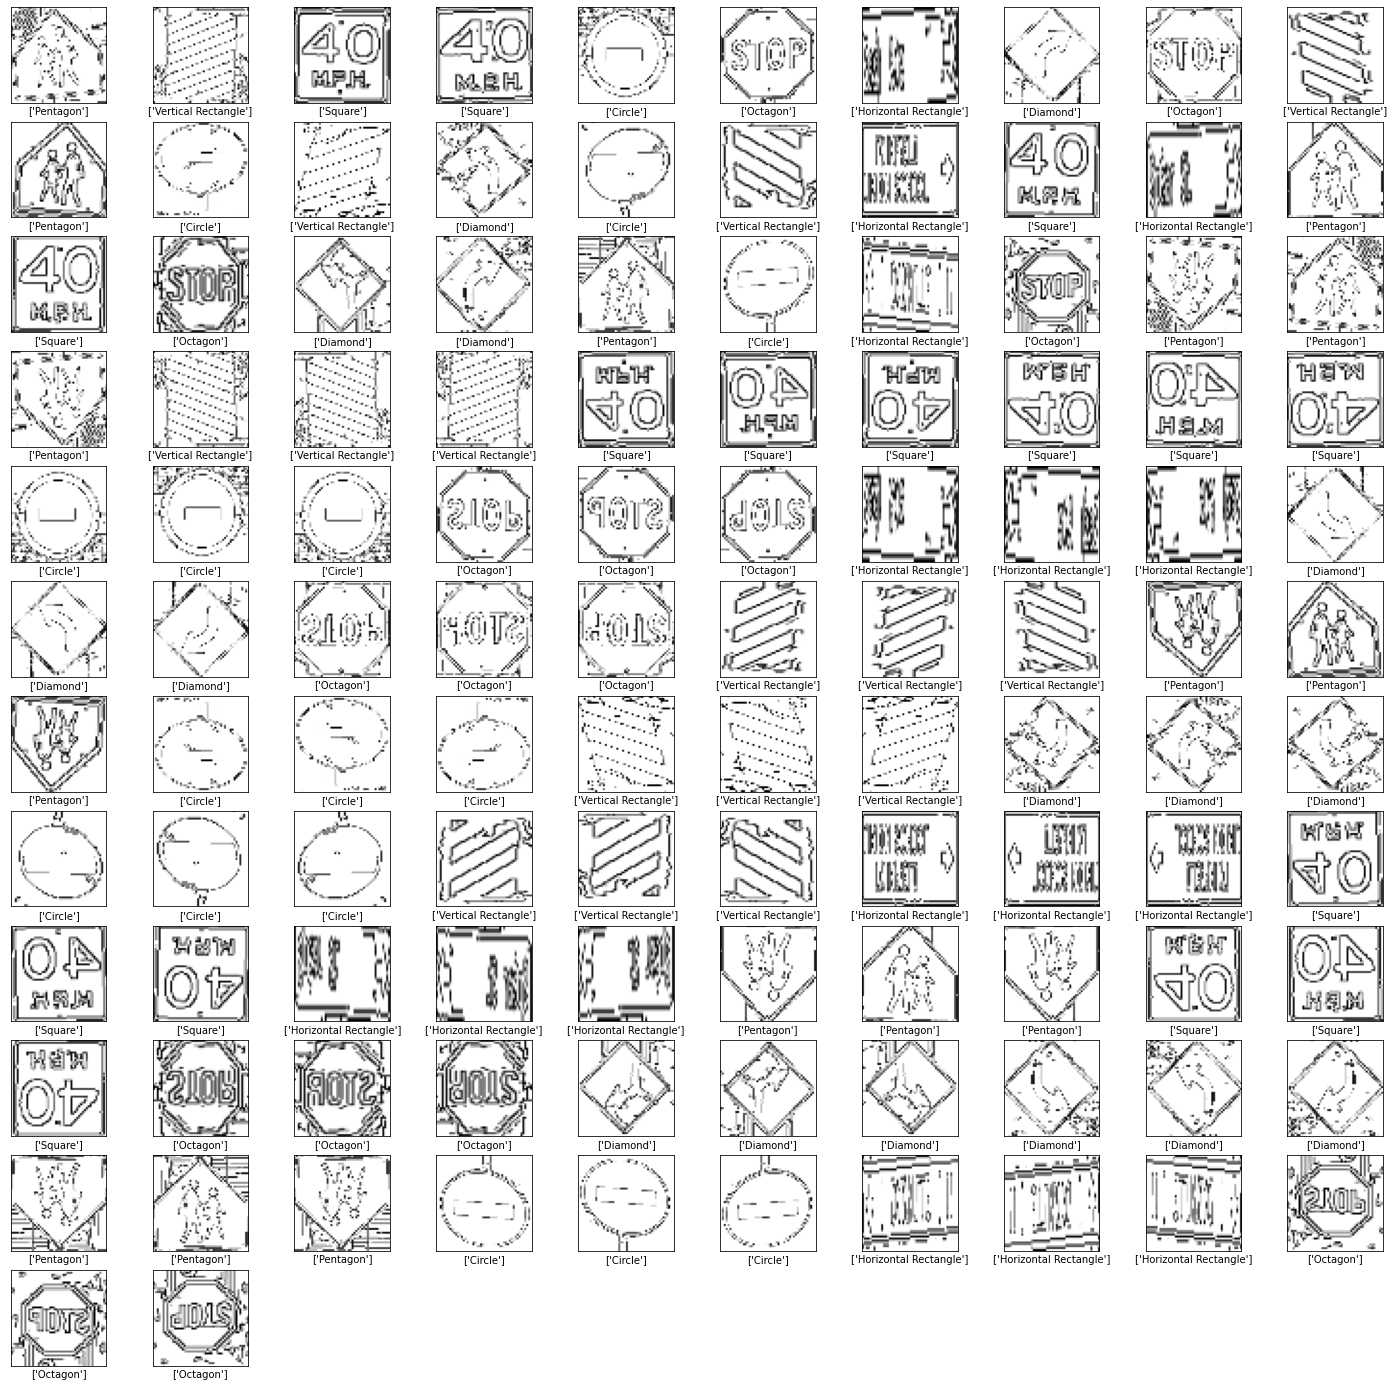

In [17]:
plt.figure(figsize=(25,25))
for i, k in enumerate(trainX):
    plt.subplot(12,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainX[i].reshape(DIM, DIM), cmap=plt.cm.binary) 
    plt.xlabel([trainY[i]])
plt.show()

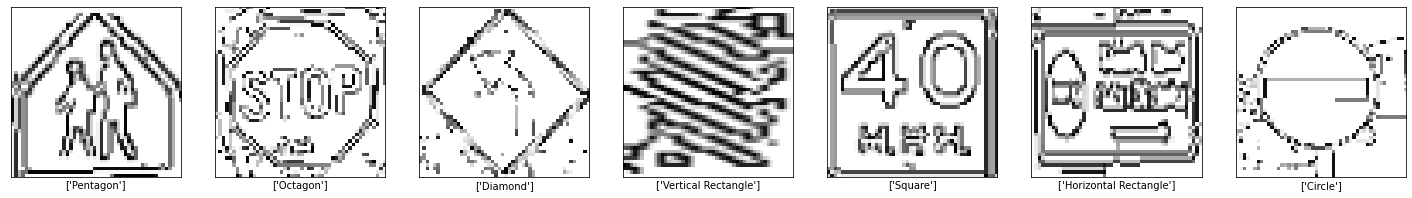

In [18]:
plt.figure(figsize=(25,25))
for i, k in enumerate(testX):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(testX[i].reshape(DIM, DIM), cmap=plt.cm.binary) 
    plt.xlabel([testY[i]])
plt.show()

### Model and 5 fold cross validation

In [19]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [20]:
def model_SVM(trainX, trainY, testX, testY):
  #Initializing a SVM model  
  svm =  SVC(decision_function_shape='ovr', C=0.01) #LinearSVC() #SVC(kernel='rbf') #SVC(kernel='poly') #SVC(kernel='linear')

  #Fitting the model to the training data
  svm.fit(trainX, trainY)

  #Extracting the accuracy score from the training data
  svm.score(trainX, trainY)
  
  #Extracting the accuracy score from the training data
  return svm.score(testX, testY)


In [21]:
def five_fold_cross_validation(dataset, filter):
  """
  Custom cross validation method where for each shape type we create 80% train and 20% tests
  We switch the test and train images methodologically
  Add with different filters for image processing
  """
  accuracy = []
  dataset = image_processing(dataset, filter) #removeSmallComponents(dataset)
  for seed in range(5):
    train, test = custom_train_test_split(dataset, 1, seed)
    train = data_augmentation(train)
    trainX, trainY = split_dataset(train)
    testX, testY   = split_dataset(test)

    accuracy.append(model_SVM(trainX, trainY, testX, testY))
  return (sum(accuracy) / len(accuracy) )

In [22]:
five_fold_cross_validation(dataset, 'c')

0.7428571428571429

### Remarks
The contents of accuracy are:
- 0.7142857142857143,
- 0.7142857142857143,
- 0.7142857142857143,
- 0.5714285714285714,
- 1.0

We get an average score of **74%**. 

Notice how one split has easier test split resulting in 100% accuracy. 


### Running the model on your own data

In [23]:
#Initializing a SVM model  
svm =  SVC(decision_function_shape='ovr', C=0.01)

#Fitting the model to the training data
svm.fit(trainX, trainY)

#Extracting the accuracy score from the training data
print("Score on Train:", svm.score(trainX, trainY))

#Extracting the accuracy score from the training data
print("Score on Train:",svm.score(testX, testY))

Score on Train: 1.0
Score on Train: 0.7142857142857143


### Visualize performance on Test

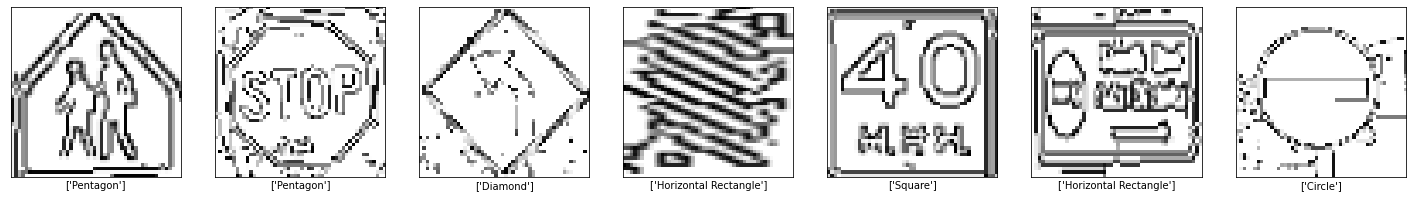

In [24]:
predict = svm.predict(testX)

plt.figure(figsize=(25,25))
for i, k in enumerate(testX):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(testX[i].reshape(DIM, DIM), cmap=plt.cm.binary) 
    plt.xlabel([predict[i]])
plt.show()

In [25]:
# Update per need "/content/road-sign-dataset/images" 
your_img_path = "/content/road-sign-dataset/images"  #"/content/road-sign-dataset/test"


In [26]:
def test_model(your_img_path):
  """
  Takes path to your images.
  Does the same image processing and preparation
  Applies the model on images
  Plots the results
  """
  your_img_name = os.listdir(your_img_path)
  your_dataset = {}

  for filename in your_img_name:
    your_dataset[filename] = (cv2.imread(your_img_path + '/' + filename), None)

  your_processed_dataset = image_processing(your_dataset)
  your_img, _ = split_dataset(your_processed_dataset)

  predicted = svm.predict(your_img)

  plt.figure(figsize=(20,20))
  for i, k in enumerate(your_dataset):
      plt.subplot(7,7,i+1)              #   CHANGE IF YOUR SET IS BIGGER
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(your_dataset[k][0][...,::-1], cmap=plt.cm.binary) #Cv2 has it in BGR, the indexing is to get RGB
      plt.xlabel(predicted[i])
  plt.show()


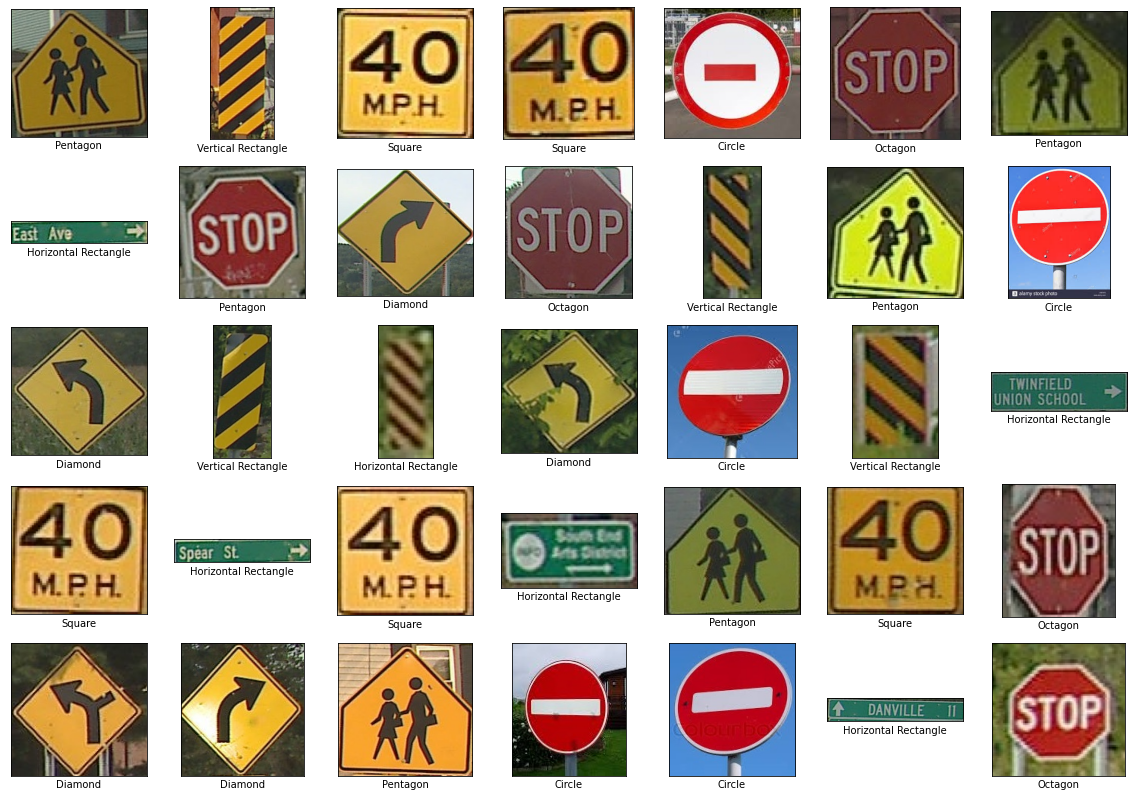

In [27]:
test_model(your_img_path)